In [1]:
import pandas as pd
import os
from tensorflow.python.client import device_lib
from keras.models import Sequential, load_model, Model
from keras.layers import Dense, Flatten, Dropout, BatchNormalization
from keras.layers.merge import concatenate
from keras.utils import plot_model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.regularizers import l1, l2, l1_l2
from keras.backend import clear_session

import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import matplotlib.image as image
from matplotlib.offsetbox import OffsetImage,AnchoredOffsetbox

import numpy as np
import sys

from scipy.stats import linregress
from sklearn.metrics import mean_squared_error

from math import sqrt
import math
from echoAI.Activation.TF_Keras.custom_activation import CELU
from bayes_opt import BayesianOptimization

Using TensorFlow backend.


In [2]:
cwd = os.path.join(os.getenv("HOME"),'Reorganization','ml')
input_path = os.path.join(cwd,'input')
output_path = os.path.join(cwd,'output')

In [3]:
def nn_model(n_cols, lambda_l1 = 0.2, lambda_l2 = 0.2, dropout = [0.1369,0.14,0.14], layers = [100,100,100]):
    model = Sequential()
    model.add(Dense(layers[0], kernel_initializer = 'uniform', input_shape=(n_cols,)))
    CELU()
    model.add(BatchNormalization())
    model.add(Dropout(dropout[0]))
    for idx, layer in enumerate(layers[1:]):
        model.add(Dense(layer, kernel_initializer = 'uniform', kernel_regularizer = l2(lambda_l2)))
        CELU()
        model.add(Dropout(dropout[idx+1]))
    model.add(Dense(1, activation='linear'))
    #model.compile(optimizer='adam', loss='mean_squared_error', metrics = ['mse', 'mae'])
    model.compile(optimizer='adam', loss='mean_squared_error', metrics = ['mse', 'mae'])
    return model

## Read file

In [29]:
data_df = pd.read_csv('reorganization_energy_data_ECFP.csv')

In [30]:
data_df = data_df[data_df['DFT λ'] > 0]
data_df = data_df[data_df['DFT λ'] < 1]

In [31]:
#data_df['1/(DFT λ)'] = data_df['DFT λ'].apply(lambda x: 1/x)

In [32]:
data_df = data_df.sample(frac = 1).copy(deep = True).reset_index(drop = True)

In [33]:
print('Number of features (m):',len(data_df.columns))
print('Number of data points (n):',len(data_df))

Number of features (m): 2230
Number of data points (n): 7466


In [34]:
print('Dimers: ' + str(len(data_df[data_df['Oligomer Length'] == 2])))
print('Tetramers: ' + str(len(data_df[data_df['Oligomer Length'] == 4])))
print('Hexamers: ' + str(len(data_df[data_df['Oligomer Length'] == 6])))

Dimers: 0
Tetramers: 7068
Hexamers: 398


In [35]:
data_df.describe()

,ECFP_0,ECFP_1,ECFP_2,ECFP_3,ECFP_4,ECFP_5,ECFP_6,ECFP_7,ECFP_8,ECFP_9,...,Cation Angle,Mean Angle,Delta Angle,Neutral Bond Length,Cation Bond Length,Mean Bond Length,Delta Bond Length,NitroNum,CarbAcidNum,DFT λ
count,7466.000000,7466.000000,7466.000000,7466.000000,7466.000000,7466.000000,7466.000000,7466.000000,7466.000000,7466.000000,...,7466.000000,7466.000000,7466.000000,7466.000000,7466.000000,7466.000000,7466.000000,7466.000000,7466.000000,7466.000000
mean,0.016073,0.025047,0.016609,0.027726,0.033217,0.027860,0.035226,0.061479,0.042995,0.010447,...,166.680523,164.445710,5.060751,1.421911,1.408381,1.415146,0.013755,0.330967,0.010983,0.486706
std,0.125764,0.156278,0.127808,0.164197,0.179215,0.164582,0.184364,0.240222,0.202859,0.101684,...,10.664186,11.834939,5.007673,0.007691,0.007614,0.007120,0.005033,0.986390,0.147813,0.169702
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,112.233877,110.848546,0.002659,1.387590,1.381233,1.384852,0.000008,0.000000,0.000000,0.014890
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,160.231225,157.188424,1.587526,1.417424,1.403697,1.411056,0.011060,0.000000,0.000000,0.361666
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,169.186170,167.111935,3.764298,1.422224,1.408163,1.415518,0.014623,0.000000,0.000000,0.452773
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,175.366256,173.947000,6.923972,1.426702,1.412779,1.419603,0.017130,0.000000,0.000000,0.587076
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,179.962772,179.947654,61.368500,1.448500,1.444010,1.444976,0.044637,8.000000,2.000000,0.999154


### Drop Features

In [36]:
#data_df = data_df.drop(['Neutral Angle', 'Delta Angle', 'Delta Bond Length'], axis = 1)

### List Features

In [37]:
cols = list(dict.fromkeys([x.split('_')[0] for x in data_df.drop(['DFT λ'], axis = 1).columns]))

In [38]:
cols

['ECFP',
 'MACCS',
 'PiSystemSize',
 'Oligomer Length',
 'Monomer 1',
 'Monomer 2',
 'Neutral Angle',
 'Cation Angle',
 'Mean Angle',
 'Delta Angle',
 'Neutral Bond Length',
 'Cation Bond Length',
 'Mean Bond Length',
 'Delta Bond Length',
 'NitroNum',
 'CarbAcidNum']

## Make training and testing sets

In [39]:
test_size = round(len(data_df)*0.15)

print('Test Size: {0} ({1}%)'.format(test_size,20))

X = data_df.drop(['DFT λ'], axis = 1)
y = data_df['DFT λ']

train_X = X[test_size:]
train_y = y[test_size:]

test_X = X[:test_size]
test_y = y[:test_size]
n_cols = len(X.columns)

Test Size: 1120 (20%)


## RF Regressor

In [40]:
regr = RandomForestRegressor(n_estimators = 1000, random_state=0)

In [41]:
regr.fit(train_X, train_y)

RandomForestRegressor(n_estimators=1000, random_state=0)

In [42]:
regr.score(test_X, test_y)

0.6462517324545296

In [43]:
test_y_predictions = np.asarray(regr.predict(test_X))

In [44]:
%%time
pdf = data_df[['Oligomer Length','Monomer 1','Monomer 2']][:test_size]
#pdf = pdf[['Oligomer Length','Monomer 1 DFT λ','Monomer 2 DFT λ']].copy(deep = True)
pdf['DFT λ'] = np.asarray(test_y)
pdf['Trained λ'] =  [x for x in list(test_y_predictions)]
#pdf['Trained λ'] =  [x[0] for x in list(test_y_predictions)]
pdf['PctDiff'] = (abs(pdf['DFT λ']-pdf['Trained λ'])/pdf['DFT λ'])*100

#pdf = pdf.merge(data_df[['Oligomer Length', 'Monomer 1', 'Monomer 2']], on=['Oligomer Length'])
#pdf.copy(deep=True)[['Monomer 1', 'Monomer 2', 'Oligomer Length', 'DFT λ', 'Trained λ', 'PctDiff']]
#pdf['Monomer 1'] = pdf['Monomer 1'].astype('int')
#pdf['Monomer 2'] = pdf['Monomer 2'].astype('int')

pdf = pdf.copy(deep = True)[pdf['Trained λ'] < 1].reset_index(drop = True)
#pdf = pdf.copy(deep = True)[pdf['Trained λ'] > 0.0].reset_index(drop = True)
pdf = pdf.copy(deep = True)[pdf['DFT λ'] < 1].reset_index(drop = True)
#pdf = pdf.copy(deep = True)[pdf['DFT λ'] > 0.0].reset_index(drop = True)
#pdf.drop_duplicates(subset = ['Monomer 1', 'Monomer 2'], inplace = True, ignore_index = True)

CPU times: user 5.18 ms, sys: 0 ns, total: 5.18 ms
Wall time: 5.18 ms


In [45]:
pdf.sort_values(['PctDiff'])

,Oligomer Length,Monomer 1,Monomer 2,DFT λ,Trained λ,PctDiff
832,4,45,234,0.799535,0.799678,0.017876
141,4,72,83,0.452993,0.452844,0.032746
316,4,39,75,0.429649,0.429336,0.072836
895,4,17,281,0.624917,0.624369,0.087756
670,4,230,307,0.599869,0.600484,0.102501
...,...,...,...,...,...,...
105,4,45,61,0.261294,0.524055,100.561461
292,4,7,297,0.267893,0.544384,103.209218
1038,4,102,127,0.332087,0.686026,106.580389
37,6,45,47,0.191033,0.540862,183.125405


In [46]:
print('Dimers: ' + str(len(pdf[pdf['Oligomer Length'] == 2])))
print('Tetramers: ' + str(len(pdf[pdf['Oligomer Length'] == 4])))
print('Hexamers: ' + str(len(pdf[pdf['Oligomer Length'] == 6])))

Dimers: 0
Tetramers: 1061
Hexamers: 59


In [47]:
cols = list(dict.fromkeys([x.split('_')[0] for x in data_df.drop(['DFT λ'], axis = 1).columns]))

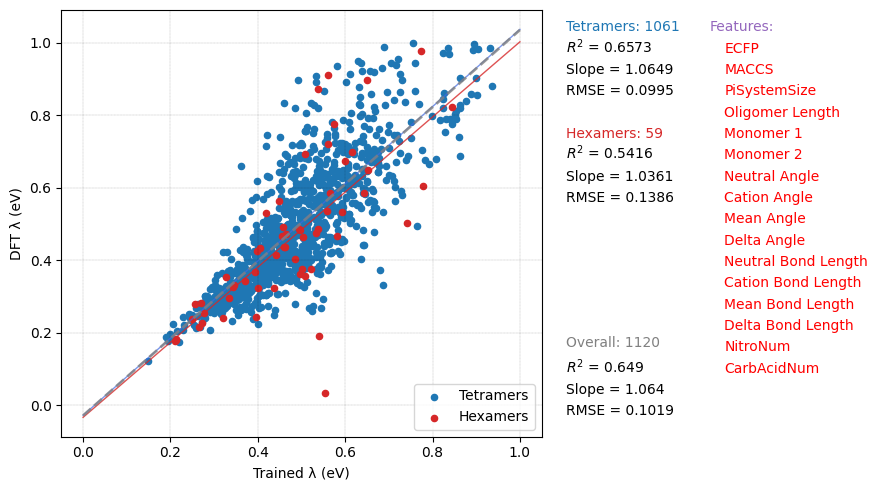

In [48]:
fig=plt.figure(figsize=(10, 5), dpi= 100, facecolor='w', edgecolor='k')
plt.grid(color='k', ls = '-.', lw = 0.1)
#plt.xlim(0,1)
#plt.ylim(0,1)
reg_x = np.arange(0,1.1,0.1)
#plt.scatter(pdf['Trained λ'], pdf['DFT λ'], s = 3, c = 'royalblue')

if len(pdf[pdf['Oligomer Length'] == 4]) > 0:
    plt.scatter(pdf[pdf['Oligomer Length'] == 4]['Trained λ'], pdf[pdf['Oligomer Length'] == 4]['DFT λ'], s = 20, c = 'tab:blue', label = "Tetramers")
    slope, intercept, r_value, p_value, std_err = linregress(pdf[pdf['Oligomer Length'] == 4]['Trained λ'].astype(np.float),pdf[pdf['Oligomer Length'] == 4]['DFT λ'])
    plt.plot(reg_x,slope*reg_x + intercept, c = 'royalblue', lw = 1, alpha = 0.7)
    plt.annotate("Tetramers: " + str(len(pdf[pdf['Oligomer Length'] == 4])), xy = (1.05,0.95), xycoords='axes fraction', color = 'tab:blue')
    plt.annotate("$R^2$ = " + str(round(r_value**2,4)), xy = (1.05,0.90), xycoords='axes fraction')
    plt.annotate("Slope = " + str(round(slope,4)), xy = (1.05,0.85), xycoords='axes fraction')
    rmse = sqrt(mean_squared_error(pdf[pdf['Oligomer Length'] == 4]['Trained λ'],pdf[pdf['Oligomer Length'] == 4]['DFT λ']))
    plt.annotate("RMSE = " + str(round(rmse,4)), xy = (1.05,0.80), xycoords='axes fraction')
    
if len(pdf[pdf['Oligomer Length'] == 6]) > 0:
    plt.scatter(pdf[pdf['Oligomer Length'] == 6]['Trained λ'], pdf[pdf['Oligomer Length'] == 6]['DFT λ'], s = 20, c = 'tab:red', label = "Hexamers")
    slope, intercept, r_value, p_value, std_err = linregress(pdf[pdf['Oligomer Length'] == 6]['Trained λ'].astype(np.float),pdf[pdf['Oligomer Length'] == 6]['DFT λ'])
    plt.plot(reg_x,slope*reg_x + intercept, c = 'tab:red', lw = 1, alpha = 0.8)
    plt.annotate("Hexamers: " + str(len(pdf[pdf['Oligomer Length'] == 6])), xy = (1.05,0.7), xycoords='axes fraction', color = 'tab:red')
    plt.annotate("$R^2$ = " + str(round(r_value**2,4)), xy = (1.05,0.65), xycoords='axes fraction')
    plt.annotate("Slope = " + str(round(slope,4)), xy = (1.05,0.60), xycoords='axes fraction')
    rmse = sqrt(mean_squared_error(pdf[pdf['Oligomer Length'] == 6]['Trained λ'],pdf[pdf['Oligomer Length'] == 6]['DFT λ']))
    plt.annotate("RMSE = " + str(round(rmse,4)), xy = (1.05,0.55), xycoords='axes fraction')

slope, intercept, r_value, p_value, std_err = linregress(pdf['Trained λ'].astype(np.float),pdf['DFT λ'])
plt.plot(reg_x,slope*reg_x + intercept, c = 'gray',ls = '--', lw = 2, alpha = 0.8)
plt.annotate("Overall: " + str(len(pdf)), xy = (1.05,0.21), xycoords='axes fraction', color = 'gray')
plt.annotate("$R^2$ = " + str(round(r_value**2,4)), xy = (1.05,0.15), xycoords='axes fraction')
plt.annotate("Slope = " + str(round(slope,4)), xy = (1.05,0.1), xycoords='axes fraction')
rmse = sqrt(mean_squared_error(pdf['Trained λ'],pdf['DFT λ']))
plt.annotate("RMSE = " + str(round(rmse,4)), xy = (1.05,0.05), xycoords='axes fraction')
plt.annotate('Features:', xy = (1.35,0.95), xycoords='axes fraction', color = 'tab:purple')
for idx, item in enumerate(cols):
    plt.annotate(item, xy = (1.38,0.90-(idx*0.05)), xycoords='axes fraction', color = 'red')
plt.xlabel('Trained λ (eV)')
plt.ylabel('DFT λ (eV)')
plt.legend(loc = 4)
plt.tight_layout()
#plt.savefig('RF_reg_test2.png')
plt.show()

## Single model

In [15]:
m = nn_model(n_cols, layers = [127, 109], dropout =[0.005,0.488])
m.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 127)               283210    
_________________________________________________________________
batch_normalization_1 (Batch (None, 127)               508       
_________________________________________________________________
dropout_1 (Dropout)          (None, 127)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 109)               13952     
_________________________________________________________________
dropout_2 (Dropout)          (None, 109)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 110       
Total params: 297,780
Trainable params: 297,526
Non-trainable params: 254
______________________________________________

In [16]:
%%time
early_stopping_monitor = EarlyStopping(monitor = 'val_loss', 
                                       patience = 150, 
                                       restore_best_weights = True, 
                                       min_delta = 1e-3, 
                                       mode = "min")
mcp_save = ModelCheckpoint('mdl_wts.hdf5', 
                           save_best_only = True, 
                           monitor = 'val_loss', 
                           mode = 'min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', 
                                   factor = 0.8, 
                                   patience = 50, 
                                   verbose = 1, 
                                   min_delta = 1e-3, 
                                   mode = 'min')
history = m.fit(train_X, train_y, 
                epochs = 1000, 
                callbacks = [ mcp_save, reduce_lr_loss, early_stopping_monitor],
                validation_split = 0.2)

Train on 5227 samples, validate on 1307 samples
Epoch 1/1000
5227/5227 [==============================] - 2s 310us/step - loss: 3.9361 - mse: 2.5842 - mae: 1.0630 - val_loss: 5.2913 - val_mse: 4.5381 - val_mae: 1.0707
Epoch 2/1000
5227/5227 [==============================] - 1s 204us/step - loss: 1.6883 - mse: 1.1838 - mae: 0.5950 - val_loss: 4.1155 - val_mse: 3.8012 - val_mae: 0.6565
Epoch 3/1000
5227/5227 [==============================] - 1s 193us/step - loss: 1.2960 - mse: 1.0780 - mae: 0.5208 - val_loss: 3.8898 - val_mse: 3.7213 - val_mae: 0.6045
Epoch 4/1000
5227/5227 [==============================] - 1s 197us/step - loss: 1.2076 - mse: 1.0850 - mae: 0.5358 - val_loss: 3.7108 - val_mse: 3.6183 - val_mae: 0.5174
Epoch 5/1000
5227/5227 [==============================] - 1s 197us/step - loss: 1.1299 - mse: 1.0452 - mae: 0.5378 - val_loss: 3.6396 - val_mse: 3.5797 - val_mae: 0.4870
Epoch 6/1000
5227/5227 [==============================] - 1s 198us/step - loss: 1.0397 - mse: 0.9814 -

In [17]:
score = m.evaluate(test_X,test_y)
for index, metric in enumerate(m.metrics_names):
        print("Test {}: {}".format(metric, score[index]))

1153/1153 [==============================] - 0s 45us/step
Test loss: 0.33782516742013685
Test mse: 0.29469722509384155
Test mae: 0.41150885820388794


In [18]:
test_y_predictions = np.asarray(m.predict(test_X))

In [22]:
%%time
pdf = data_df[['Oligomer Length','Monomer 1','Monomer 2']][:test_size]
#pdf = pdf[['Oligomer Length','Monomer 1 DFT λ','Monomer 2 DFT λ']].copy(deep = True)
pdf['DFT λ'] = np.asarray(test_y)
pdf['Trained λ'] =  [x[0] for x in list(test_y_predictions)]
pdf['PctDiff'] = (abs(pdf['DFT λ']-pdf['Trained λ'])/pdf['DFT λ'])*100

#pdf = pdf.merge(data_df[['Oligomer Length', 'Monomer 1', 'Monomer 2']], on=['Oligomer Length'])
#pdf.copy(deep=True)[['Monomer 1', 'Monomer 2', 'Oligomer Length', 'DFT λ', 'Trained λ', 'PctDiff']]
#pdf['Monomer 1'] = pdf['Monomer 1'].astype('int')
#pdf['Monomer 2'] = pdf['Monomer 2'].astype('int')

pdf = pdf.copy(deep = True)[pdf['Trained λ'] < 1].reset_index(drop = True)
#pdf = pdf.copy(deep = True)[pdf['Trained λ'] > 0.0].reset_index(drop = True)
pdf = pdf.copy(deep = True)[pdf['DFT λ'] < 1].reset_index(drop = True)
#pdf = pdf.copy(deep = True)[pdf['DFT λ'] > 0.0].reset_index(drop = True)
#pdf.drop_duplicates(subset = ['Monomer 1', 'Monomer 2'], inplace = True, ignore_index = True)

CPU times: user 6.99 ms, sys: 0 ns, total: 6.99 ms
Wall time: 7 ms


In [23]:
pdf.sort_values(['PctDiff'])

,Oligomer Length,Monomer 1,Monomer 2,DFT λ,Trained λ,PctDiff
835,4,41,86,0.384307,0.384103,0.053044
749,4,59,79,0.414235,0.413970,0.063934
809,4,1,89,0.420473,0.420178,0.070144
528,4,62,263,0.657211,0.656720,0.074724
575,4,3,72,0.448419,0.448792,0.083041
...,...,...,...,...,...,...
834,4,15,303,0.294054,0.546974,86.011200
315,4,198,254,0.372487,0.720277,93.369849
499,4,118,281,0.341821,0.679687,98.842767
559,4,198,230,0.452927,0.913981,101.794394


In [24]:
print('Dimers: ' + str(len(pdf[pdf['Oligomer Length'] == 2])))
print('Tetramers: ' + str(len(pdf[pdf['Oligomer Length'] == 4])))
print('Hexamers: ' + str(len(pdf[pdf['Oligomer Length'] == 6])))

Dimers: 0
Tetramers: 1059
Hexamers: 54


In [25]:
cols = list(dict.fromkeys([x.split('_')[0] for x in data_df.drop(['DFT λ'], axis = 1).columns]))

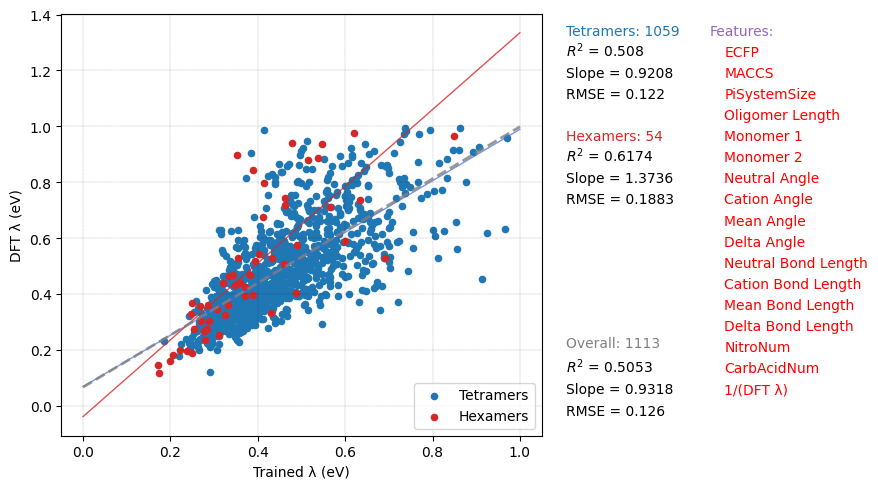

In [26]:
fig=plt.figure(figsize=(10, 5), dpi= 100, facecolor='w', edgecolor='k')
plt.grid(color='k', ls = '-.', lw = 0.1)
#plt.xlim(0,1)
#plt.ylim(0,1)
reg_x = np.arange(0,1.1,0.1)
#plt.scatter(pdf['Trained λ'], pdf['DFT λ'], s = 3, c = 'royalblue')

if len(pdf[pdf['Oligomer Length'] == 4]) > 0:
    plt.scatter(pdf[pdf['Oligomer Length'] == 4]['Trained λ'], pdf[pdf['Oligomer Length'] == 4]['DFT λ'], s = 20, c = 'tab:blue', label = "Tetramers")
    slope, intercept, r_value, p_value, std_err = linregress(pdf[pdf['Oligomer Length'] == 4]['Trained λ'].astype(np.float),pdf[pdf['Oligomer Length'] == 4]['DFT λ'])
    plt.plot(reg_x,slope*reg_x + intercept, c = 'royalblue', lw = 1, alpha = 0.7)
    plt.annotate("Tetramers: " + str(len(pdf[pdf['Oligomer Length'] == 4])), xy = (1.05,0.95), xycoords='axes fraction', color = 'tab:blue')
    plt.annotate("$R^2$ = " + str(round(r_value**2,4)), xy = (1.05,0.90), xycoords='axes fraction')
    plt.annotate("Slope = " + str(round(slope,4)), xy = (1.05,0.85), xycoords='axes fraction')
    rmse = sqrt(mean_squared_error(pdf[pdf['Oligomer Length'] == 4]['Trained λ'],pdf[pdf['Oligomer Length'] == 4]['DFT λ']))
    plt.annotate("RMSE = " + str(round(rmse,4)), xy = (1.05,0.80), xycoords='axes fraction')
    
if len(pdf[pdf['Oligomer Length'] == 6]) > 0:
    plt.scatter(pdf[pdf['Oligomer Length'] == 6]['Trained λ'], pdf[pdf['Oligomer Length'] == 6]['DFT λ'], s = 20, c = 'tab:red', label = "Hexamers")
    slope, intercept, r_value, p_value, std_err = linregress(pdf[pdf['Oligomer Length'] == 6]['Trained λ'].astype(np.float),pdf[pdf['Oligomer Length'] == 6]['DFT λ'])
    plt.plot(reg_x,slope*reg_x + intercept, c = 'tab:red', lw = 1, alpha = 0.8)
    plt.annotate("Hexamers: " + str(len(pdf[pdf['Oligomer Length'] == 6])), xy = (1.05,0.7), xycoords='axes fraction', color = 'tab:red')
    plt.annotate("$R^2$ = " + str(round(r_value**2,4)), xy = (1.05,0.65), xycoords='axes fraction')
    plt.annotate("Slope = " + str(round(slope,4)), xy = (1.05,0.60), xycoords='axes fraction')
    rmse = sqrt(mean_squared_error(pdf[pdf['Oligomer Length'] == 6]['Trained λ'],pdf[pdf['Oligomer Length'] == 6]['DFT λ']))
    plt.annotate("RMSE = " + str(round(rmse,4)), xy = (1.05,0.55), xycoords='axes fraction')

slope, intercept, r_value, p_value, std_err = linregress(pdf['Trained λ'].astype(np.float),pdf['DFT λ'])
plt.plot(reg_x,slope*reg_x + intercept, c = 'gray',ls = '--', lw = 2, alpha = 0.8)
plt.annotate("Overall: " + str(len(pdf)), xy = (1.05,0.21), xycoords='axes fraction', color = 'gray')
plt.annotate("$R^2$ = " + str(round(r_value**2,4)), xy = (1.05,0.15), xycoords='axes fraction')
plt.annotate("Slope = " + str(round(slope,4)), xy = (1.05,0.1), xycoords='axes fraction')
rmse = sqrt(mean_squared_error(pdf['Trained λ'],pdf['DFT λ']))
plt.annotate("RMSE = " + str(round(rmse,4)), xy = (1.05,0.05), xycoords='axes fraction')
plt.annotate('Features:', xy = (1.35,0.95), xycoords='axes fraction', color = 'tab:purple')
for idx, item in enumerate(cols):
    plt.annotate(item, xy = (1.38,0.90-(idx*0.05)), xycoords='axes fraction', color = 'red')
plt.xlabel('Trained λ (eV)')
plt.ylabel('DFT λ (eV)')
plt.legend(loc = 4)
plt.tight_layout()
#plt.savefig('ML_?.png')
plt.show()

## Ensamble

In [33]:
for i in range(5):
    modelName = 'ensambleModels/ensamble_model_1_' + str(i) + '.hdf5'
    m = nn_model(n_cols)

    early_stopping_monitor = EarlyStopping(monitor = 'val_loss', 
                                           patience = 150, 
                                           restore_best_weights = True, 
                                           min_delta = 1e-3, 
                                           mode = "min")
    mcp_save = ModelCheckpoint(modelName, 
                               save_best_only = True, 
                               monitor = 'val_loss', 
                               mode = 'min')
    reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', 
                                       factor = 0.8, 
                                       patience = 50, 
                                       verbose = 1, 
                                       min_delta = 1e-3, 
                                       mode = 'min')
    history = m.fit(train_X, train_y, 
                    epochs = 1000, 
                    callbacks = [ mcp_save, reduce_lr_loss, early_stopping_monitor],
                    validation_split = 0.2)

Train on 5227 samples, validate on 1307 samples
Epoch 1/1000
5227/5227 [==============================] - 1s 270us/step - loss: 0.3976 - mse: 0.0614 - mae: 0.1580 - val_loss: 0.0454 - val_mse: 0.0371 - val_mae: 0.1626
Epoch 2/1000
5227/5227 [==============================] - 1s 184us/step - loss: 0.0427 - mse: 0.0351 - mae: 0.1068 - val_loss: 0.0362 - val_mse: 0.0277 - val_mae: 0.1417
Epoch 3/1000
5227/5227 [==============================] - 1s 190us/step - loss: 0.0419 - mse: 0.0340 - mae: 0.1064 - val_loss: 0.0281 - val_mse: 0.0176 - val_mae: 0.0946
Epoch 4/1000
5227/5227 [==============================] - 1s 178us/step - loss: 0.0412 - mse: 0.0327 - mae: 0.1018 - val_loss: 0.0240 - val_mse: 0.0170 - val_mae: 0.1010
Epoch 5/1000
5227/5227 [==============================] - 1s 183us/step - loss: 0.0417 - mse: 0.0331 - mae: 0.1040 - val_loss: 0.0350 - val_mse: 0.0271 - val_mae: 0.1349
Epoch 6/1000
5227/5227 [==============================] - 1s 180us/step - loss: 0.0423 - mse: 0.0322 -

In [34]:
def load_all_models(n_models):
    all_models = list()
    for i in range(n_models):
        # define filename for this ensemble
        filename = 'ensambleModels/ensamble_model_1_' + str(i) + '.hdf5'
        # load model from file
        model = load_model(filename)
        # add to list of members
        all_models.append(model)
        print('>loaded %s' % filename)
    return all_models

In [35]:
# define stacked model from multiple member input models
def define_stacked_model(members):
    # update all layers in all models to not be trainable
    for i in range(len(members)):
        model = members[i]
        for layer in model.layers:
            # make not trainable
            layer.trainable = False
            # rename to avoid 'unique layer name' issue
            layer._name = 'ensemble_' + str(i+1) + '_' + layer.name
    # define multi-headed input
    ensemble_visible = [model.input for model in members]
    # concatenate merge output from each model
    ensemble_outputs = [model.output for model in members]
    merge = concatenate(ensemble_outputs)
    hidden = Dense(10, activation='relu')(merge)
    output = Dense(1, activation='relu')(hidden)
    model = Model(inputs=ensemble_visible, outputs=output)
    # plot graph of ensemble
    plot_model(model, show_shapes=True, to_file='model_graph.png')
    # compile
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse', 'mae'])
    return model

In [36]:
# fit a stacked model
def fit_stacked_model(model, inputX, inputy):
    # prepare input data
    X = [inputX for _ in range(len(model.input))]
    # encode output data
    inputy_enc = inputy
    # fit model
    model.fit(X, inputy_enc, epochs=300, verbose=0)


In [37]:
# make a prediction with a stacked model
def predict_stacked_model(model, inputX):
    # prepare input data
    X = [inputX for _ in range(len(model.input))]
    # make prediction
    return model.predict(X, verbose=0)

In [38]:
n_members = 5
members = load_all_models(n_members)
print('Loaded %d models' % len(members))

>loaded ensambleModels/ensamble_model_1_0.hdf5
>loaded ensambleModels/ensamble_model_1_1.hdf5
>loaded ensambleModels/ensamble_model_1_2.hdf5
>loaded ensambleModels/ensamble_model_1_3.hdf5
>loaded ensambleModels/ensamble_model_1_4.hdf5
Loaded 5 models


In [39]:
stacked_model = define_stacked_model(members)

In [40]:
fit_stacked_model(stacked_model, test_X, test_y)

In [41]:
yhat = predict_stacked_model(stacked_model, test_X)

In [42]:
yhat

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)

In [43]:
list(dict.fromkeys([x.split('_')[0] for x in test_X.columns]))

['ECFP',
 'MACCS',
 'PiSystemSize',
 'Oligomer Length',
 'Monomer 1',
 'Monomer 2',
 'Cation Angle',
 'Mean Angle',
 'Neutral Bond Length',
 'Cation Bond Length',
 'Mean Bond Length',
 'NitroNum',
 'CarbAcidNum']

In [44]:
test_y_predictions = yhat #np.asarray(m.predict(test_X))

In [45]:
%%time
pdf = data_df[['Oligomer Length','Monomer 1','Monomer 2']][:test_size]
#pdf = pdf[['Oligomer Length','Monomer 1 DFT λ','Monomer 2 DFT λ']].copy(deep = True)
pdf['DFT λ'] = test_y
pdf['Trained λ'] =  [x[0] for x in list(test_y_predictions)]
pdf['PctDiff'] = (abs(pdf['DFT λ']-pdf['Trained λ'])/pdf['DFT λ'])*100

#pdf = pdf.merge(data_df[['Oligomer Length', 'Monomer 1', 'Monomer 2']], on=['Oligomer Length'])
#pdf.copy(deep=True)[['Monomer 1', 'Monomer 2', 'Oligomer Length', 'DFT λ', 'Trained λ', 'PctDiff']]
#pdf['Monomer 1'] = pdf['Monomer 1'].astype('int')
#pdf['Monomer 2'] = pdf['Monomer 2'].astype('int')

pdf = pdf.copy(deep = True)[pdf['Trained λ'] < 3].reset_index(drop = True)
#pdf = pdf.copy(deep = True)[pdf['Trained λ'] > 0.0].reset_index(drop = True)
pdf = pdf.copy(deep = True)[pdf['DFT λ'] < 3].reset_index(drop = True)
#pdf = pdf.copy(deep = True)[pdf['DFT λ'] > 0.0].reset_index(drop = True)
#pdf.drop_duplicates(subset = ['Monomer 1', 'Monomer 2'], inplace = True, ignore_index = True)

CPU times: user 4.93 ms, sys: 1.99 ms, total: 6.92 ms
Wall time: 6.93 ms


In [46]:
pdf.sort_values(['PctDiff'])

,Oligomer Length,Monomer 1,Monomer 2,DFT λ,Trained λ,PctDiff
0,4,61,64,0.361319,0.0,100.0
771,4,112,263,0.354356,0.0,100.0
770,4,45,191,0.904021,0.0,100.0
769,4,46,77,0.292368,0.0,100.0
768,4,167,292,0.399511,0.0,100.0
...,...,...,...,...,...,...
381,4,22,26,0.574384,0.0,100.0
380,4,49,62,0.470556,0.0,100.0
379,6,45,81,0.776171,0.0,100.0
1150,4,37,76,0.383868,0.0,100.0


In [47]:
print('Dimers: ' + str(len(pdf[pdf['Oligomer Length'] == 2])))
print('Tetramers: ' + str(len(pdf[pdf['Oligomer Length'] == 4])))
print('Hexamers: ' + str(len(pdf[pdf['Oligomer Length'] == 6])))

Dimers: 0
Tetramers: 1086
Hexamers: 66


In [48]:
cols = list(dict.fromkeys([x.split('_')[0] for x in data_df.drop(['DFT λ'], axis = 1).columns]))

/ihome/ghutchison/oda6/.virtualenvs/rdkit/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/ihome/ghutchison/oda6/.virtualenvs/rdkit/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: divide by zero encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)
/ihome/ghutchison/oda6/.virtualenvs/rdkit/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/ihome/ghutchison/oda6/.virtualenvs/rdkit/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: divide by zero encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)
/ihome/ghutchison/oda6/.virtualenvs/rdkit/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_s

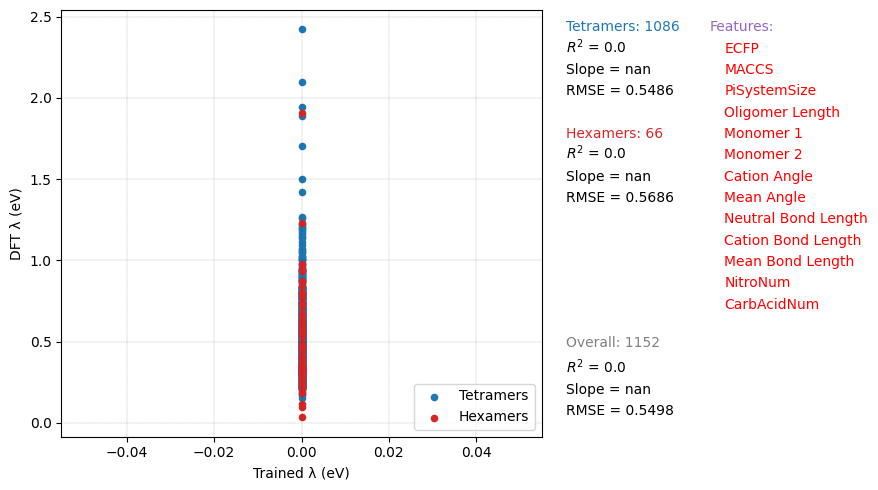

In [49]:
fig=plt.figure(figsize=(10, 5), dpi= 100, facecolor='w', edgecolor='k')
plt.grid(color='k', ls = '-.', lw = 0.1)
#plt.xlim(0,1)
#plt.ylim(0,1)
reg_x = np.arange(0,1.1,0.1)
#plt.scatter(pdf['Trained λ'], pdf['DFT λ'], s = 3, c = 'royalblue')

if len(pdf[pdf['Oligomer Length'] == 4]) > 0:
    plt.scatter(pdf[pdf['Oligomer Length'] == 4]['Trained λ'], pdf[pdf['Oligomer Length'] == 4]['DFT λ'], s = 20, c = 'tab:blue', label = "Tetramers")
    slope, intercept, r_value, p_value, std_err = linregress(pdf[pdf['Oligomer Length'] == 4]['Trained λ'].astype(np.float),pdf[pdf['Oligomer Length'] == 4]['DFT λ'])
    plt.plot(reg_x,slope*reg_x + intercept, c = 'royalblue', lw = 1, alpha = 0.7)
    plt.annotate("Tetramers: " + str(len(pdf[pdf['Oligomer Length'] == 4])), xy = (1.05,0.95), xycoords='axes fraction', color = 'tab:blue')
    plt.annotate("$R^2$ = " + str(round(r_value**2,4)), xy = (1.05,0.90), xycoords='axes fraction')
    plt.annotate("Slope = " + str(round(slope,4)), xy = (1.05,0.85), xycoords='axes fraction')
    rmse = sqrt(mean_squared_error(pdf[pdf['Oligomer Length'] == 4]['Trained λ'],pdf[pdf['Oligomer Length'] == 4]['DFT λ']))
    plt.annotate("RMSE = " + str(round(rmse,4)), xy = (1.05,0.80), xycoords='axes fraction')
    
if len(pdf[pdf['Oligomer Length'] == 6]) > 0:
    plt.scatter(pdf[pdf['Oligomer Length'] == 6]['Trained λ'], pdf[pdf['Oligomer Length'] == 6]['DFT λ'], s = 20, c = 'tab:red', label = "Hexamers")
    slope, intercept, r_value, p_value, std_err = linregress(pdf[pdf['Oligomer Length'] == 6]['Trained λ'].astype(np.float),pdf[pdf['Oligomer Length'] == 6]['DFT λ'])
    plt.plot(reg_x,slope*reg_x + intercept, c = 'tab:red', lw = 1, alpha = 0.8)
    plt.annotate("Hexamers: " + str(len(pdf[pdf['Oligomer Length'] == 6])), xy = (1.05,0.7), xycoords='axes fraction', color = 'tab:red')
    plt.annotate("$R^2$ = " + str(round(r_value**2,4)), xy = (1.05,0.65), xycoords='axes fraction')
    plt.annotate("Slope = " + str(round(slope,4)), xy = (1.05,0.60), xycoords='axes fraction')
    rmse = sqrt(mean_squared_error(pdf[pdf['Oligomer Length'] == 6]['Trained λ'],pdf[pdf['Oligomer Length'] == 6]['DFT λ']))
    plt.annotate("RMSE = " + str(round(rmse,4)), xy = (1.05,0.55), xycoords='axes fraction')

slope, intercept, r_value, p_value, std_err = linregress(pdf['Trained λ'].astype(np.float),pdf['DFT λ'])
plt.plot(reg_x,slope*reg_x + intercept, c = 'gray',ls = '--', lw = 2, alpha = 0.8)
plt.annotate("Overall: " + str(len(pdf)), xy = (1.05,0.21), xycoords='axes fraction', color = 'gray')
plt.annotate("$R^2$ = " + str(round(r_value**2,4)), xy = (1.05,0.15), xycoords='axes fraction')
plt.annotate("Slope = " + str(round(slope,4)), xy = (1.05,0.1), xycoords='axes fraction')
rmse = sqrt(mean_squared_error(pdf['Trained λ'],pdf['DFT λ']))
plt.annotate("RMSE = " + str(round(rmse,4)), xy = (1.05,0.05), xycoords='axes fraction')
plt.annotate('Features:', xy = (1.35,0.95), xycoords='axes fraction', color = 'tab:purple')
for idx, item in enumerate(cols):
    plt.annotate(item, xy = (1.38,0.90-(idx*0.05)), xycoords='axes fraction', color = 'red')
plt.xlabel('Trained λ (eV)')
plt.ylabel('DFT λ (eV)')
plt.legend(loc = 4)
plt.tight_layout()
#plt.savefig('ML_post_round5.png')
plt.show()

---

### GFN2 vs. DFT angles & bond lengths

---

## Get new tetramers with low lambda

In [32]:
all_tetramers = pd.read_csv('all_possible_tetramers.csv')

In [33]:
list(dict.fromkeys([x.split('_')[0] for x in all_tetramers.columns]))

['ECFP',
 'MACCS',
 'PiSystemSize',
 'Oligomer Length',
 'Monomer 1',
 'Monomer 2',
 'Neutral Angle',
 'Cation Angle',
 'Mean Angle',
 'Delta Angle',
 'Neutral Bond Length',
 'Cation Bond Length',
 'Mean Bond Length',
 'Delta Bond Length',
 'NitroNum',
 'CarbAcidNum']

In [34]:
print(len(data_df[data_df['Oligomer Length'] == 4]))
print(len(all_tetramers))

7279
31878


In [35]:
new_tetramers = pd.concat([data_df[data_df['Oligomer Length'] == 4], all_tetramers]).drop_duplicates(subset = ['Monomer 1', 'Monomer 2'], keep = False)

In [36]:
print(len(new_tetramers))

25105


In [37]:
new_tetramers.drop(['DFT λ'], axis = 1, inplace = True)

In [38]:
new_tetramers.describe()

,ECFP_0,ECFP_1,ECFP_2,ECFP_3,ECFP_4,ECFP_5,ECFP_6,ECFP_7,ECFP_8,ECFP_9,...,Neutral Angle,Cation Angle,Mean Angle,Delta Angle,Neutral Bond Length,Cation Bond Length,Mean Bond Length,Delta Bond Length,NitroNum,CarbAcidNum
count,25105.000000,25105.000000,25105.000000,25105.000000,25105.000000,25105.000000,25105.000000,25105.000000,25105.000000,25105.000000,...,25105.000000,25105.000000,25105.000000,25105.000000,25105.000000,25105.000000,25105.000000,25105.000000,25105.000000,25105.000000
mean,0.026130,0.040749,0.029715,0.013941,0.027763,0.025493,0.045847,0.060386,0.030831,0.010755,...,156.522291,162.711177,159.616734,7.269170,1.423421,1.408688,1.416054,0.014974,0.388847,0.034575
std,0.159526,0.197712,0.169804,0.117250,0.164297,0.157620,0.209158,0.238206,0.172862,0.103148,...,15.020765,11.440043,12.792928,6.619728,0.008810,0.007706,0.007737,0.005231,1.004294,0.262513
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,96.544385,97.040895,101.823726,0.001291,1.390490,1.381324,1.385967,0.000001,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,147.005449,155.508165,151.685671,2.676097,1.417651,1.403845,1.411093,0.012029,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,158.593158,164.507942,161.289765,5.518856,1.423453,1.408661,1.416277,0.015459,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,168.229422,171.613430,169.561787,9.721855,1.429435,1.413201,1.421115,0.018247,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,179.952803,179.958676,179.922737,63.870256,1.451295,1.449766,1.447500,0.041585,8.000000,4.000000


In [23]:
#new_tetramers = new_tetramers.drop(['DFT λ'], axis = 1)

In [39]:
list(dict.fromkeys([x.split('_')[0] for x in new_tetramers.columns]))

['ECFP',
 'MACCS',
 'PiSystemSize',
 'Oligomer Length',
 'Monomer 1',
 'Monomer 2',
 'Neutral Angle',
 'Cation Angle',
 'Mean Angle',
 'Delta Angle',
 'Neutral Bond Length',
 'Cation Bond Length',
 'Mean Bond Length',
 'Delta Bond Length',
 'NitroNum',
 'CarbAcidNum']

In [40]:
tetra_predictions = predict_stacked_model(stacked_model, new_tetramers) # m.predict(new_tetramers)

In [41]:
new_tetramers['Trained λ'] = tetra_predictions

In [42]:
tet_below = 0.3

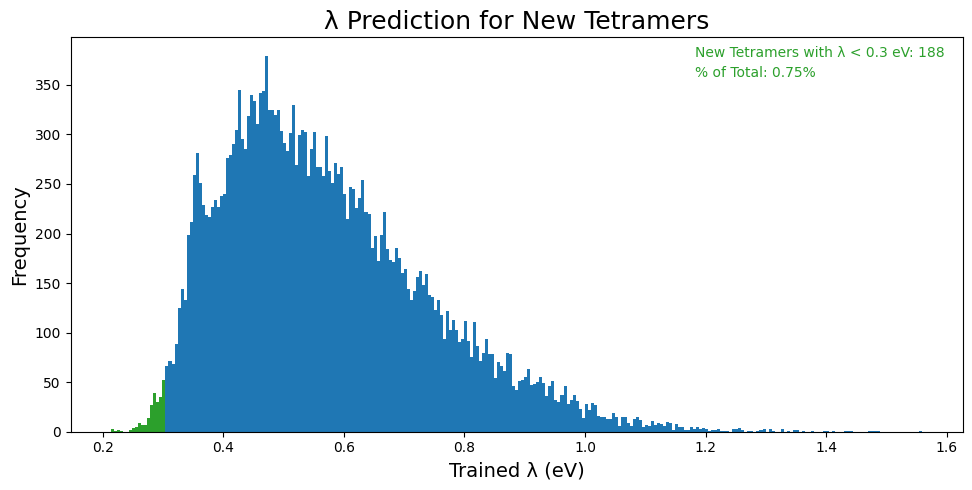

In [43]:
bin_width = 0.005
fig=plt.figure(figsize=(10, 5), dpi= 100, facecolor='w', edgecolor='k')
n, bins, patches = plt.hist(new_tetramers['Trained λ'], bins = np.arange(min(new_tetramers['Trained λ']), max(new_tetramers['Trained λ']) + bin_width, bin_width), color = 'tab:blue')
for index, t_bin in enumerate(bins):
    if t_bin < tet_below:
        patches[index].set_fc('tab:green')
new_tetra = len(new_tetramers[new_tetramers['Trained λ'] < tet_below])
new_tetra_pct = len(new_tetramers[new_tetramers['Trained λ'] < tet_below])*100 / len(new_tetramers)
plt.annotate(f'New Tetramers with λ < {tet_below} eV: {new_tetra}', xy = (0.7,0.95), xycoords='axes fraction', color = 'tab:green')
plt.annotate('% of Total: {:.2f}%'.format(new_tetra_pct), xy = (0.7,0.9), xycoords='axes fraction', color = 'tab:green')
plt.title('λ Prediction for New Tetramers', fontsize = 18)
plt.xlabel('Trained λ (eV)', fontsize = 14)
plt.ylabel('Frequency', fontsize = 14)
plt.tight_layout()
plt.savefig('ensambleModels/model_1.png')
plt.show()

In [29]:
new_tetramers[new_tetramers['Trained λ'] < tet_below].sort_values(by=['Trained λ'])[['Monomer 1', 'Monomer 2', 'Trained λ']].to_csv('ensambleModels/model_1.csv', index = False)

---
## Get new Hexamers with low lambda

In [55]:
all_hexamers = pd.read_csv('all_possible_hexamers.csv')

In [56]:
all_hexamers['Monomer 1'] = all_hexamers['Monomer 1'].astype('int64')
all_hexamers['Monomer 2'] = all_hexamers['Monomer 2'].astype('int64')

In [65]:
list(dict.fromkeys([(x.split('_')[0], all_hexamers[x].dtype) for x in all_hexamers.columns]))

[('ECFP', dtype('int64')),
 ('MACCS', dtype('int64')),
 ('PiSystemSize', dtype('int64')),
 ('Oligomer Length', dtype('int64')),
 ('Monomer 1', dtype('int64')),
 ('Monomer 2', dtype('int64')),
 ('Neutral Angle', dtype('float64')),
 ('Cation Angle', dtype('float64')),
 ('Mean Angle', dtype('float64')),
 ('Delta Angle', dtype('float64')),
 ('Neutral Bond Length', dtype('float64')),
 ('Cation Bond Length', dtype('float64')),
 ('Mean Bond Length', dtype('float64')),
 ('Delta Bond Length', dtype('float64')),
 ('NitroNum', dtype('int64')),
 ('CarbAcidNum', dtype('int64'))]

In [58]:
print(len(data_df[data_df['Oligomer Length'] == 6]))
print(len(all_hexamers))

408
32130


In [59]:
len(all_hexamers.drop_duplicates(subset = ['Monomer 1', 'Monomer 2'], keep = False))

32130

In [60]:
new_hexamers = pd.concat([data_df[data_df['Oligomer Length'] == 6], all_hexamers]).drop_duplicates(subset = ['Monomer 1', 'Monomer 2'], keep = False)

In [61]:
print(len(new_hexamers))

31722


In [62]:
new_hexamers.drop(['DFT λ'], axis = 1, inplace = True)

In [63]:
new_hexamers.describe()

,ECFP_0,ECFP_1,ECFP_2,ECFP_3,ECFP_4,ECFP_5,ECFP_6,ECFP_7,ECFP_8,ECFP_9,...,Neutral Angle,Cation Angle,Mean Angle,Delta Angle,Neutral Bond Length,Cation Bond Length,Mean Bond Length,Delta Bond Length,NitroNum,CarbAcidNum
count,31722.000000,31722.000000,31722.000000,31722.000000,31722.000000,31722.000000,31722.000000,31722.000000,31722.000000,31722.000000,...,31722.000000,31722.000000,31722.000000,31722.000000,31722.000000,31722.000000,31722.000000,31722.000000,31722.000000,31722.0
mean,0.001671,0.001828,0.001103,0.003342,0.004224,0.004287,0.879516,0.008259,0.006242,0.001545,...,157.767890,162.524017,160.145954,4.859031,1.421651,1.410505,1.416078,0.011221,2.730282,0.0
std,0.040841,0.042721,0.033199,0.057710,0.064857,0.065338,0.325532,0.090506,0.078759,0.039273,...,14.103449,11.297714,12.579527,4.373071,0.009530,0.008730,0.008920,0.003760,0.991886,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,93.161860,105.291068,102.613059,0.000406,1.381457,1.377643,1.379550,0.000003,0.000000,0.0
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,149.344156,155.576203,152.498217,1.831284,1.415766,1.405003,1.410586,0.009309,3.000000,0.0
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,159.807295,164.263924,161.983505,3.705047,1.422171,1.411128,1.416750,0.011654,3.000000,0.0
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,168.570038,171.229589,169.844393,6.491508,1.428026,1.416044,1.421979,0.013501,3.000000,0.0
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,179.957188,179.984679,179.969479,42.948436,1.480121,1.463386,1.451470,0.057302,12.000000,0.0


In [66]:
hexa_predictions = predict_stacked_model(stacked_model, new_hexamers)#  m.predict(new_hexamers)

In [67]:
new_hexamers['Trained λ'] = hexa_predictions

In [68]:
new_hexamers[new_hexamers['Trained λ'] < 0.4].sort_values(by=['Trained λ'])[['Monomer 1', 'Monomer 2', 'Trained λ']]

,Monomer 1,Monomer 2,Trained λ
2355,43,50,0.199006
2736,50,60,0.231710
2502,46,50,0.234141
1942,36,44,0.234427
822,2,50,0.236751
...,...,...,...
2139,39,79,0.399786
32029,274,274,0.399787
859,2,86,0.399798
547,16,83,0.399865


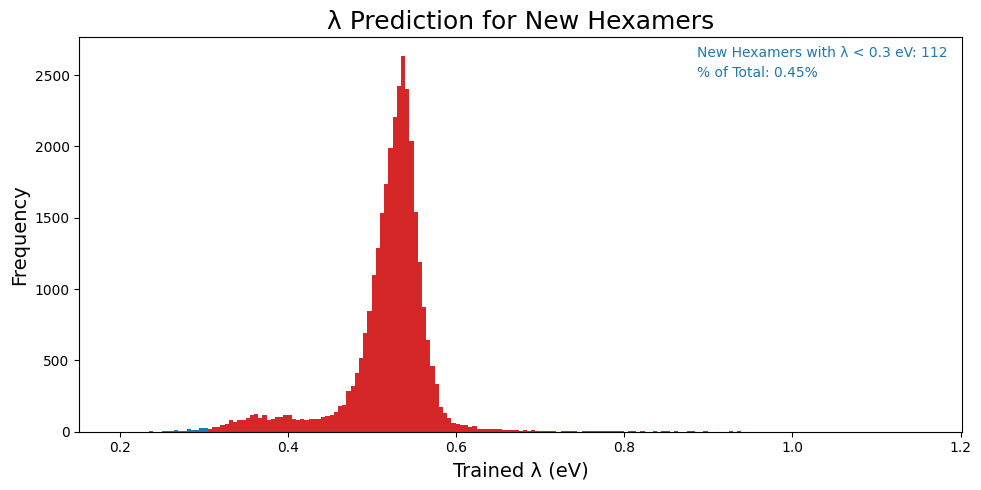

In [69]:
bin_width = 0.005
fig=plt.figure(figsize=(10, 5), dpi= 100, facecolor='w', edgecolor='k')
n, bins, patches = plt.hist(new_hexamers['Trained λ'], bins = np.arange(min(new_hexamers['Trained λ']), max(new_hexamers['Trained λ']) + bin_width, bin_width), color = 'tab:red')
for index, t_bin in enumerate(bins):
    if t_bin < tet_below:
        patches[index].set_fc('tab:blue')
new_hexa = len(new_hexamers[new_hexamers['Trained λ'] < tet_below])
new_hexa_pct = len(new_hexamers[new_hexamers['Trained λ'] < tet_below])*100 / len(new_tetramers)
plt.annotate(f'New Hexamers with λ < {tet_below} eV: {new_hexa}', xy = (0.7,0.95), xycoords='axes fraction', color = 'tab:blue')
plt.annotate('% of Total: {:.2f}%'.format(new_hexa_pct), xy = (0.7,0.9), xycoords='axes fraction', color = 'tab:blue')
plt.title('λ Prediction for New Hexamers', fontsize = 18)
plt.xlabel('Trained λ (eV)', fontsize = 14)
plt.ylabel('Frequency', fontsize = 14)
plt.tight_layout()
#plt.savefig('ensambleModels/model_1.png')
plt.show()

---

In [35]:
bin_1 = data_df[data_df['Predicted bin'] == 1]

In [36]:
len(bin_1)

4404

In [37]:
bin_1.describe()

,ECFP_0,ECFP_1,ECFP_2,ECFP_3,ECFP_4,ECFP_5,ECFP_6,ECFP_7,ECFP_8,ECFP_9,...,Cation Angle,Delta Angle,Neutral Bond Length,Cation Bond Length,Delta Bond Length,NitroNum,CarbAcidNum,DFT λ,bin,Predicted bin
count,4404.000000,4404.000000,4404.000000,4404.000000,4404.000000,4404.000000,4404.000000,4404.000000,4404.000000,4404.000000,...,4404.000000,4404.000000,4404.000000,4404.000000,4404.000000,4404.000000,4404.000000,4404.000000,4404.000000,4404.0
mean,0.017711,0.017711,0.016349,0.024523,0.034741,0.029973,0.034514,0.060854,0.041099,0.011807,...,168.887401,3.567379,1.419398,1.407165,0.012521,0.309037,0.003633,0.377948,1.022025,1.0
std,0.131915,0.131915,0.126827,0.154684,0.183144,0.170531,0.182566,0.239089,0.198542,0.108031,...,10.010870,3.708316,0.007117,0.008034,0.004791,0.942643,0.085174,0.084669,0.149846,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,113.819051,0.002659,1.387590,1.381233,0.000008,0.000000,0.000000,0.014890,1.000000,1.0
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,163.363623,1.065392,1.415157,1.401950,0.009812,0.000000,0.000000,0.322673,1.000000,1.0
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,171.646356,2.625802,1.419894,1.406678,0.013539,0.000000,0.000000,0.379362,1.000000,1.0
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,176.997225,4.930155,1.424109,1.411834,0.016021,0.000000,0.000000,0.436092,1.000000,1.0
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,179.962772,43.839176,1.448069,1.440162,0.039065,8.000000,2.000000,1.887485,3.000000,1.0


In [38]:
bin_1 = bin_1.sample(frac = 1).copy(deep = True).reset_index(drop = True)

In [39]:
test_size = round(len(bin_1)*0.2)

print('Test Size: {0} ({1}%)'.format(test_size,20))

X = bin_1.drop(['DFT λ', 'bin', 'Predicted bin'], axis = 1)
y = bin_1['DFT λ']

train_X = X[test_size:]
train_y = y[test_size:]

test_X = X[:test_size]
test_y = y[:test_size]
n_cols = len(X.columns)

Test Size: 881 (20%)


In [40]:
m2 = nn_model(n_cols, layers = [100,100])
m2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 100)               222800    
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               400       
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_5 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 101       
Total params: 233,401
Trainable params: 233,201
Non-trainable params: 200
______________________________________________

In [41]:
%%time
early_stopping_monitor = EarlyStopping(monitor = 'val_loss', 
                                       patience = 150, 
                                       restore_best_weights = True, 
                                       min_delta = 1e-3, 
                                       mode = "min")
mcp_save = ModelCheckpoint('mdl_wts.hdf5', 
                           save_best_only = True, 
                           monitor = 'val_loss', 
                           mode = 'min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', 
                                   factor = 0.8, 
                                   patience = 50, 
                                   verbose = 1, 
                                   min_delta = 1e-3, 
                                   mode = 'min')
history = m2.fit(train_X, train_y, 
                epochs = 1000, 
                callbacks = [ mcp_save, reduce_lr_loss, early_stopping_monitor],
                validation_split = 0.2)

Train on 2818 samples, validate on 705 samples
Epoch 1/1000
2818/2818 [==============================] - 1s 326us/step - loss: 0.3772 - mse: 0.0395 - mae: 0.1333 - val_loss: 0.0246 - val_mse: 0.0338 - val_mae: 0.1712
Epoch 2/1000
2818/2818 [==============================] - 1s 182us/step - loss: 0.0059 - mse: 0.0086 - mae: 0.0669 - val_loss: 0.0100 - val_mse: 0.0193 - val_mae: 0.1204
Epoch 3/1000
2818/2818 [==============================] - 1s 183us/step - loss: 0.0042 - mse: 0.0074 - mae: 0.0627 - val_loss: 0.0038 - val_mse: 0.0066 - val_mae: 0.0613
Epoch 4/1000
2818/2818 [==============================] - 1s 182us/step - loss: 0.0035 - mse: 0.0063 - mae: 0.0565 - val_loss: 0.0053 - val_mse: 0.0098 - val_mae: 0.0797
Epoch 5/1000
2818/2818 [==============================] - 1s 186us/step - loss: 0.0050 - mse: 0.0089 - mae: 0.0670 - val_loss: 0.0047 - val_mse: 0.0083 - val_mae: 0.0687
Epoch 6/1000
2818/2818 [==============================] - 1s 183us/step - loss: 0.0038 - mse: 0.0066 - 

In [42]:
score = m2.evaluate(test_X,test_y)
for index, metric in enumerate(m.metrics_names):
        print("Test {}: {}".format(metric, score[index]))

881/881 [==============================] - 0s 46us/step
Test loss: 0.0028435475651225526
Test mse: 0.005026310682296753
Test mae: 0.052933305501937866


In [43]:
test_y_predictions = np.asarray(m2.predict(test_X))

In [44]:
%%time
pdf = data_df[['Oligomer Length','Monomer 1','Monomer 2']][:test_size]
#pdf = pdf[['Oligomer Length','Monomer 1 DFT λ','Monomer 2 DFT λ']].copy(deep = True)
pdf['DFT λ'] = test_y
pdf['Trained λ'] =  [x[0] for x in list(test_y_predictions)]
pdf['PctDiff'] = (abs(pdf['DFT λ']-pdf['Trained λ'])/pdf['DFT λ'])*100

#pdf = pdf.merge(data_df[['Oligomer Length', 'Monomer 1', 'Monomer 2']], on=['Oligomer Length'])
#pdf.copy(deep=True)[['Monomer 1', 'Monomer 2', 'Oligomer Length', 'DFT λ', 'Trained λ', 'PctDiff']]
#pdf['Monomer 1'] = pdf['Monomer 1'].astype('int')
#pdf['Monomer 2'] = pdf['Monomer 2'].astype('int')

pdf = pdf.copy(deep = True)[pdf['Trained λ'] < 3].reset_index(drop = True)
#pdf = pdf.copy(deep = True)[pdf['Trained λ'] > 0.0].reset_index(drop = True)
pdf = pdf.copy(deep = True)[pdf['DFT λ'] < 3].reset_index(drop = True)
#pdf = pdf.copy(deep = True)[pdf['DFT λ'] > 0.0].reset_index(drop = True)
#pdf.drop_duplicates(subset = ['Monomer 1', 'Monomer 2'], inplace = True, ignore_index = True)

CPU times: user 5.45 ms, sys: 6 µs, total: 5.45 ms
Wall time: 5.48 ms


In [45]:
pdf.sort_values(['PctDiff'])

,Length,Monomer 1,Monomer 2,DFT λ,Trained λ,PctDiff
823,4,64,74,0.423502,0.423355,0.034653
747,4,58,96,0.416758,0.416904,0.035012
719,4,112,179,0.407691,0.407497,0.047649
252,4,17,223,0.424292,0.423960,0.078180
92,4,3,19,0.479774,0.480159,0.080199
...,...,...,...,...,...,...
720,4,238,245,0.230811,0.505673,119.085675
708,4,4,50,0.209142,0.517846,147.605692
746,4,288,309,0.087837,0.262738,199.120773
80,4,62,96,0.131122,0.419661,220.053307


In [46]:
print('Dimers: ' + str(len(pdf[pdf['Oligomer Length'] == 2])))
print('Tetramers: ' + str(len(pdf[pdf['Oligomer Length'] == 4])))
print('Hexamers: ' + str(len(pdf[pdf['Oligomer Length'] == 6])))

Dimers: 0
Tetramers: 826
Hexamers: 55


In [47]:
cols = list(dict.fromkeys([x.split('_')[0] for x in data_df.drop(['DFT λ', 'bin'], axis = 1).columns]))

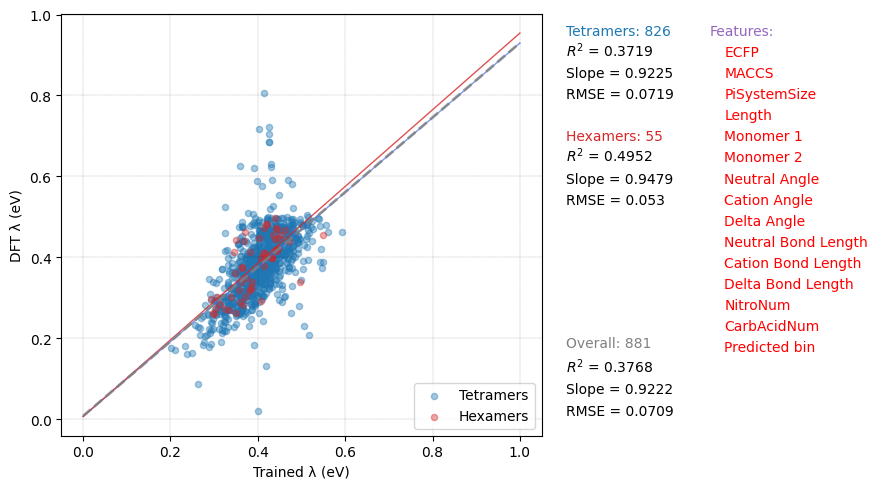

In [53]:
fig=plt.figure(figsize=(10, 5), dpi= 100, facecolor='w', edgecolor='k')
plt.grid(color='k', ls = '-.', lw = 0.1)
#plt.xlim(0,1)
#plt.ylim(0,1)
reg_x = np.arange(0,1.1,0.1)
#plt.scatter(pdf['Trained λ'], pdf['DFT λ'], s = 3, c = 'royalblue')

if len(pdf[pdf['Oligomer Length'] == 4]) > 0:
    plt.scatter(pdf[pdf['Oligomer Length'] == 4]['Trained λ'], pdf[pdf['Oligomer Length'] == 4]['DFT λ'], s = 20, c = 'tab:blue', label = "Tetramers", alpha = 0.4)
    slope, intercept, r_value, p_value, std_err = linregress(pdf[pdf['Oligomer Length'] == 4]['Trained λ'].astype(np.float),pdf[pdf['Oligomer Length'] == 4]['DFT λ'])
    plt.plot(reg_x,slope*reg_x + intercept, c = 'royalblue', lw = 1, alpha = 0.7)
    plt.annotate("Tetramers: " + str(len(pdf[pdf['Oligomer Length'] == 4])), xy = (1.05,0.95), xycoords='axes fraction', color = 'tab:blue')
    plt.annotate("$R^2$ = " + str(round(r_value**2,4)), xy = (1.05,0.90), xycoords='axes fraction')
    plt.annotate("Slope = " + str(round(slope,4)), xy = (1.05,0.85), xycoords='axes fraction')
    rmse = sqrt(mean_squared_error(pdf[pdf['Oligomer Length'] == 4]['Trained λ'],pdf[pdf['Oligomer Length'] == 4]['DFT λ']))
    plt.annotate("RMSE = " + str(round(rmse,4)), xy = (1.05,0.80), xycoords='axes fraction')
    
if len(pdf[pdf['Oligomer Length'] == 6]) > 0:
    plt.scatter(pdf[pdf['Oligomer Length'] == 6]['Trained λ'], pdf[pdf['Oligomer Length'] == 6]['DFT λ'], s = 20, c = 'tab:red', label = "Hexamers", alpha = 0.4)
    slope, intercept, r_value, p_value, std_err = linregress(pdf[pdf['Oligomer Length'] == 6]['Trained λ'].astype(np.float),pdf[pdf['Oligomer Length'] == 6]['DFT λ'])
    plt.plot(reg_x,slope*reg_x + intercept, c = 'tab:red', lw = 1, alpha = 0.8)
    plt.annotate("Hexamers: " + str(len(pdf[pdf['Oligomer Length'] == 6])), xy = (1.05,0.7), xycoords='axes fraction', color = 'tab:red')
    plt.annotate("$R^2$ = " + str(round(r_value**2,4)), xy = (1.05,0.65), xycoords='axes fraction')
    plt.annotate("Slope = " + str(round(slope,4)), xy = (1.05,0.60), xycoords='axes fraction')
    rmse = sqrt(mean_squared_error(pdf[pdf['Oligomer Length'] == 6]['Trained λ'],pdf[pdf['Oligomer Length'] == 6]['DFT λ']))
    plt.annotate("RMSE = " + str(round(rmse,4)), xy = (1.05,0.55), xycoords='axes fraction')

slope, intercept, r_value, p_value, std_err = linregress(pdf['Trained λ'].astype(np.float),pdf['DFT λ'])
plt.plot(reg_x,slope*reg_x + intercept, c = 'gray',ls = '--', lw = 2, alpha = 0.8)
plt.annotate("Overall: " + str(len(pdf)), xy = (1.05,0.21), xycoords='axes fraction', color = 'gray')
plt.annotate("$R^2$ = " + str(round(r_value**2,4)), xy = (1.05,0.15), xycoords='axes fraction')
plt.annotate("Slope = " + str(round(slope,4)), xy = (1.05,0.1), xycoords='axes fraction')
rmse = sqrt(mean_squared_error(pdf['Trained λ'],pdf['DFT λ']))
plt.annotate("RMSE = " + str(round(rmse,4)), xy = (1.05,0.05), xycoords='axes fraction')
plt.annotate('Features:', xy = (1.35,0.95), xycoords='axes fraction', color = 'tab:purple')
for idx, item in enumerate(cols):
    plt.annotate(item, xy = (1.38,0.90-(idx*0.05)), xycoords='axes fraction', color = 'red')
plt.xlabel('Trained λ (eV)')
plt.ylabel('DFT λ (eV)')
plt.legend(loc = 4)
plt.tight_layout()
#plt.savefig('ML_post_round5.png')
plt.show()

In [50]:
pdf.sort_values(by=['DFT λ'])

,Length,Monomer 1,Monomer 2,DFT λ,Trained λ,PctDiff
532,4,45,92,0.019092,0.401042,2000.598111
746,4,288,309,0.087837,0.262738,199.120773
80,4,62,96,0.131122,0.419661,220.053307
393,4,30,67,0.160235,0.237407,48.161849
541,4,63,67,0.163307,0.250047,53.114458
...,...,...,...,...,...,...
820,4,16,39,0.685956,0.425686,37.942624
524,4,100,236,0.705651,0.426657,39.537148
442,4,12,67,0.717446,0.402857,43.848428
224,4,18,54,0.721431,0.426628,40.863618


---
---

# Bayesian Optimization of Hyperparameters

---

### Using BayesianOptimization Package

In [10]:
def bo_model(n_cols, dropout_rate, num_of_layers, layer_size):
    model = Sequential()
    model.add(Dense(int(layer_size), kernel_initializer = 'uniform', input_shape=(n_cols,)))
    CELU()
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    for i in range(int(num_of_layers)):
        model.add(Dense(int(layer_size), kernel_initializer = 'uniform'))
        CELU()
        model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='linear'))
    #model.compile(optimizer='adam', loss='mean_squared_error', metrics = ['mse', 'mae'])

    return model

In [11]:
def fit_func(n_cols, dropout_rate, num_of_layers, layer_size):
    model = bo_model(n_cols, dropout_rate, num_of_layers, layer_size)
    model.compile(optimizer='adam', loss='mean_squared_error', metrics = ['mse', 'mae'])
    early_stopping_monitor = EarlyStopping(monitor = 'val_loss', 
                                           patience = 150, 
                                           restore_best_weights = True, 
                                           min_delta = 1e-3, 
                                           mode = "min")
    
    reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', 
                                       factor = 0.8, 
                                       patience = 50, 
                                       verbose = 0, 
                                       min_delta = 1e-3, 
                                       mode = 'min')

    model.fit(train_X, train_y,
              epochs = 1000, 
              callbacks = [reduce_lr_loss, early_stopping_monitor],
              validation_split = 0.2,
              verbose = 0)
    
    #score = model.evaluate(test_X,test_y)
    test_y_predictions = model.predict(test_X)
    test_y_predictions = [x[0] for x in list(test_y_predictions)]
    #print(len(test_y_predictions))
    #for index, metric in enumerate(model.metrics_names):
    #    print("Test {}: {}".format(metric, score[index]))
    slope, intercept, r_value, p_value, std_err = linregress(test_y_predictions, test_y)
    return r_value**2

In [12]:
from functools import partial

fit_with_partial = partial(fit_func, n_cols)

In [13]:
pbounds = {
    'dropout_rate': (0.1, 0.5),
    'num_of_layers': (1, 6),
    'layer_size': (20,400)
}

In [14]:
optimizer = BayesianOptimization(
    f=fit_with_partial,
    pbounds=pbounds,
    verbose=2,  # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=1,
)

In [15]:
%%time
optimizer.maximize(init_points=5, n_iter=20)

|   iter    |  target   | dropou... | layer_... | num_of... |
-------------------------------------------------------------
|  1        |  0.2555   |  0.2668   |  293.7    |  1.001    |
|  2        |  0.2614   |  0.2209   |  75.77    |  1.462    |
|  3        |  0.2464   |  0.1745   |  151.3    |  2.984    |
|  4        |  0.2545   |  0.3155   |  179.3    |  4.426    |
|  5        |  0.2515   |  0.1818   |  353.7    |  1.137    |
|  6        |  0.2522   |  0.1026   |  76.71    |  1.301    |
|  7        |  0.2514   |  0.3129   |  319.2    |  1.874    |
|  8        |  0.2652   |  0.3383   |  119.2    |  4.734    |
|  9        |  0.2385   |  0.191    |  79.12    |  5.737    |
|  10       |  0.2573   |  0.3905   |  296.9    |  1.973    |
|  11       |  0.252    |  0.2881   |  180.9    |  3.36     |
|  12       |  0.2569   |  0.4822   |  272.3    |  3.354    |
|  13       |  0.2511   |  0.2955   |  339.6    |  5.895    |
|  14       |  0.2572   |  0.229    |  310.1    |  5.285    |
|  15   

In [16]:
for i, res in enumerate(optimizer.res):
    print("Iteration {}: \n\t{}".format(i, res))

Iteration 0: 
	{'target': 0.25552966918074477, 'params': {'dropout_rate': 0.2668088018810296, 'layer_size': 293.72330750802007, 'num_of_layers': 1.0005718740867244}}
Iteration 1: 
	{'target': 0.26144472909694627, 'params': {'dropout_rate': 0.22093302905273593, 'layer_size': 75.76723851050295, 'num_of_layers': 1.461692973843989}}
Iteration 2: 
	{'target': 0.24640952604285937, 'params': {'dropout_rate': 0.17450408455106836, 'layer_size': 151.31307627635815, 'num_of_layers': 2.9838373711533497}}
Iteration 3: 
	{'target': 0.2544922435623628, 'params': {'dropout_rate': 0.3155266936013428, 'layer_size': 179.293915473252, 'num_of_layers': 4.426097501983797}}
Iteration 4: 
	{'target': 0.2514536131449248, 'params': {'dropout_rate': 0.18178089989260698, 'layer_size': 353.68462582855926, 'num_of_layers': 1.1369379659896308}}
Iteration 5: 
	{'target': 0.25221117913327407, 'params': {'dropout_rate': 0.10257849731097655, 'layer_size': 76.71412110094172, 'num_of_layers': 1.3008694687497089}}
Iteratio

In [17]:
print(optimizer.max)

{'target': 0.2652435889597585, 'params': {'dropout_rate': 0.3383377780250608, 'layer_size': 119.18946515425398, 'num_of_layers': 4.733644780085436}}


In [18]:
for item in optimizer.max['params']:
    print("{}: {}".format(item,optimizer.max['params'][item]))

dropout_rate: 0.3383377780250608
layer_size: 119.18946515425398
num_of_layers: 4.733644780085436


In [19]:
pd.DataFrame(optimizer.max)

,target,params
dropout_rate,0.265244,0.338338
layer_size,0.265244,119.189465
num_of_layers,0.265244,4.733645


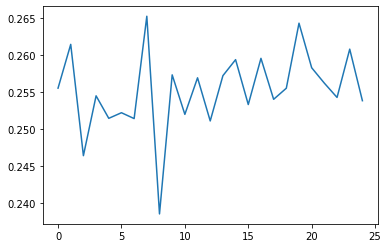

In [22]:
plt.plot([x['target'] for x in optimizer.res])
plt.show()

---

## Using Hyperas Package

In [3]:
from hyperopt import Trials, STATUS_OK, tpe
from hyperopt.hp import uniformint
from hyperas import optim
from hyperas.distributions import choice, uniform

In [4]:
def data():
    data_df = pd.read_csv('reorganization_energy_data.csv')
    data_df = data_df.sample(frac = 1).copy(deep = True).reset_index(drop = True)
    
    test_size = round(len(data_df)*0.2)

    X = data_df.drop(['DFT λ'], axis = 1)
    y = data_df['DFT λ']

    train_X = X[test_size:]
    train_y = y[test_size:]

    test_X = X[:test_size]
    test_y = y[:test_size]
    
    return train_X, train_y, test_X, test_y

In [ ]:
def clean_data(data_X, features):
    
    return data_X

In [20]:
def create_model(train_X, train_y, test_X, test_y):
    n_cols = len(train_X.columns)
    model = Sequential()
    model.add(Dense({{uniformint(20,200)}}, kernel_initializer = 'uniform', input_shape=(n_cols,)))
    CELU()
    model.add(BatchNormalization())
    model.add(Dropout({{uniform(0, 0.5)}}))
    
    layers_num = {{uniformint(0,6)}}
    if layers_num == 1:
        model.add(Dense({{uniformint(20,200)}}, kernel_initializer = 'uniform'))
        CELU()
        model.add(Dropout({{uniform(0, 0.5)}}))
    if layers_num == 2:
        model.add(Dense({{uniformint(20,200)}}, kernel_initializer = 'uniform'))
        CELU()
        model.add(Dropout({{uniform(0, 0.5)}}))
        model.add(Dense({{uniformint(20,200)}}, kernel_initializer = 'uniform'))
        CELU()
        model.add(Dropout({{uniform(0, 0.5)}}))
    if layers_num == 3:
        model.add(Dense({{uniformint(20,200)}}, kernel_initializer = 'uniform'))
        CELU()
        model.add(Dropout({{uniform(0, 0.5)}}))
        model.add(Dense({{uniformint(20,200)}}, kernel_initializer = 'uniform'))
        CELU()
        model.add(Dropout({{uniform(0, 0.5)}}))
        model.add(Dense({{uniformint(20,200)}}, kernel_initializer = 'uniform'))
        CELU()
        model.add(Dropout({{uniform(0, 0.5)}}))
    if layers_num == 4:
        model.add(Dense({{uniformint(20,200)}}, kernel_initializer = 'uniform'))
        CELU()
        model.add(Dropout({{uniform(0, 0.5)}}))
        model.add(Dense({{uniformint(20,200)}}, kernel_initializer = 'uniform'))
        CELU()
        model.add(Dropout({{uniform(0, 0.5)}}))
        model.add(Dense({{uniformint(20,200)}}, kernel_initializer = 'uniform'))
        CELU()
        model.add(Dropout({{uniform(0, 0.5)}})) 
        model.add(Dense({{uniformint(20,200)}}, kernel_initializer = 'uniform'))
        CELU()
        model.add(Dropout({{uniform(0, 0.5)}})) 
    if layers_num == 5:
        model.add(Dense({{uniformint(20,200)}}, kernel_initializer = 'uniform'))
        CELU()
        model.add(Dropout({{uniform(0, 0.5)}}))
        model.add(Dense({{uniformint(20,200)}}, kernel_initializer = 'uniform'))
        CELU()
        model.add(Dropout({{uniform(0, 0.5)}}))
        model.add(Dense({{uniformint(20,200)}}, kernel_initializer = 'uniform'))
        CELU()
        model.add(Dropout({{uniform(0, 0.5)}})) 
        model.add(Dense({{uniformint(20,200)}}, kernel_initializer = 'uniform'))
        CELU()
        model.add(Dropout({{uniform(0, 0.5)}}))
        model.add(Dense({{uniformint(20,200)}}, kernel_initializer = 'uniform'))
        CELU()
        model.add(Dropout({{uniform(0, 0.5)}}))
    if layers_num == 6:
        model.add(Dense({{uniformint(20,200)}}, kernel_initializer = 'uniform'))
        CELU()
        model.add(Dropout({{uniform(0, 0.5)}}))
        model.add(Dense({{uniformint(20,200)}}, kernel_initializer = 'uniform'))
        CELU()
        model.add(Dropout({{uniform(0, 0.5)}}))
        model.add(Dense({{uniformint(20,200)}}, kernel_initializer = 'uniform'))
        CELU()
        model.add(Dropout({{uniform(0, 0.5)}})) 
        model.add(Dense({{uniformint(20,200)}}, kernel_initializer = 'uniform'))
        CELU()
        model.add(Dropout({{uniform(0, 0.5)}}))
        model.add(Dense({{uniformint(20,200)}}, kernel_initializer = 'uniform'))
        CELU()
        model.add(Dropout({{uniform(0, 0.5)}}))
        model.add(Dense({{uniformint(20,200)}}, kernel_initializer = 'uniform'))
        CELU()
        model.add(Dropout({{uniform(0, 0.5)}}))
        
        
        
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='adam', loss='mean_squared_error', metrics = ['mse', 'mae'])

    early_stopping_monitor = EarlyStopping(monitor = 'val_loss', 
                                           patience = 150, 
                                           restore_best_weights = True, 
                                           min_delta = 1e-3, 
                                           mode = "min")
    
    reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', 
                                       factor = 0.8, 
                                       patience = 50, 
                                       verbose = 0, 
                                       min_delta = 1e-3, 
                                       mode = 'min')

    model.fit(train_X, train_y,
              epochs = 1000, 
              callbacks = [reduce_lr_loss, early_stopping_monitor],
              validation_split = 0.2,
              verbose = 0)
    
    score = model.evaluate(test_X,test_y)
    
    return {'loss': score[1], 'status': STATUS_OK, 'model': model}

In [21]:
best_run, best_model = optim.minimize(model=create_model,
                                          data=data,
                                          algo=tpe.suggest,
                                          max_evals=200,
                                          trials=Trials(),
                                          notebook_name='reorganization_ML_updated')

>>> Imports:
#coding=utf-8

try:
    import pandas as pd
except:
    pass

try:
    import os
except:
    pass

try:
    from tensorflow.python.client import device_lib
except:
    pass

try:
    from keras.models import Sequential
except:
    pass

try:
    from keras.layers import Dense, Flatten, Dropout, BatchNormalization
except:
    pass

try:
    from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
except:
    pass

try:
    from keras.regularizers import l1, l2, l1_l2
except:
    pass

try:
    import matplotlib.pyplot as plt
except:
    pass

try:
    import matplotlib.font_manager as font_manager
except:
    pass

try:
    import matplotlib.image as image
except:
    pass

try:
    from matplotlib.offsetbox import OffsetImage, AnchoredOffsetbox
except:
    pass

try:
    import numpy as np
except:
    pass

try:
    import sys
except:
    pass

try:
    import random
except:
    pass

try:
    from scipy.stats import linregress
except:
    pass

try:
 

In [22]:
X_train, Y_train, X_test, Y_test = data()
print("Evalutation of best performing model:")
print(best_model.evaluate(X_test, Y_test))
print("Best performing model chosen hyper-parameters:")
print(best_run)

Evalutation of best performing model:
1484/1484 [==============================] - 0s 26us/step
[0.015389270055034973, 0.015389271080493927, 0.08594225347042084]
Best performing model chosen hyper-parameters:
{'Dense': 24.0, 'Dense_1': 191.0, 'Dense_10': 78.0, 'Dense_11': 165.0, 'Dense_12': 177.0, 'Dense_13': 141.0, 'Dense_14': 85.0, 'Dense_15': 81.0, 'Dense_16': 50.0, 'Dense_17': 158.0, 'Dense_18': 122.0, 'Dense_19': 83.0, 'Dense_2': 164.0, 'Dense_20': 163.0, 'Dense_21': 50.0, 'Dense_3': 177.0, 'Dense_4': 104.0, 'Dense_5': 33.0, 'Dense_6': 150.0, 'Dense_7': 55.0, 'Dense_8': 77.0, 'Dense_9': 140.0, 'Dropout': 0.27811892749518574, 'Dropout_1': 0.43872881696722316, 'Dropout_10': 0.3788115866056224, 'Dropout_11': 0.10941011638933146, 'Dropout_12': 0.2824324343962277, 'Dropout_13': 0.35990920067622584, 'Dropout_14': 0.3566592813498221, 'Dropout_15': 0.34923745256347666, 'Dropout_16': 0.43857418086300803, 'Dropout_17': 0.38468064429939397, 'Dropout_18': 0.2356283686784001, 'Dropout_19': 0.2

In [34]:
pd.DataFrame(best_run.values(), index = best_run.keys(), columns = ['value']).to_csv('best_hyperparams.csv')

,value
Dense,24.000000
Dense_1,191.000000
Dense_10,78.000000
Dense_11,165.000000
Dense_12,177.000000
Dense_13,141.000000
Dense_14,85.000000
Dense_15,81.000000
Dense_16,50.000000
Dense_17,158.000000
